In [484]:
%matplotlib inline

import os,sys,inspect

PATH = '/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2'
sys.path.insert(0, PATH)

import pandas as pd
import numpy as np
import seaborn as sns

# sklearn modules
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.pipeline import Pipeline
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Input, Dropout, Activation
from keras import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

import plotly.express as px
import matplotlib.pyplot as plt
from fma_metadata import utils

import warnings
warnings.filterwarnings('ignore')

#### Preprocessing

In [485]:
# read data: features
data = utils.load('/Users/gaetanoantonicchio/Desktop/dataset_DM2/fma_metadata/features.csv')

# read labels: song_happiness
labels = pd.read_csv('/Users/gaetanoantonicchio/Documents/GitHub/DataMining-2/src/Data (cleaned)/Labels/song_happiness_labels.csv')
label= labels.set_index('track_id')

# merge labels with data
data = data.merge(labels, on='track_id')

# remove duplicate rows
data.drop_duplicates(keep=False, inplace=True)
# remove Null values (if there are)
data.dropna()

# reset index to track_id
data = data.set_index('track_id')

# view data
data.head()

,"(chroma_cens, kurtosis, 01)","(chroma_cens, kurtosis, 02)","(chroma_cens, kurtosis, 03)","(chroma_cens, kurtosis, 04)","(chroma_cens, kurtosis, 05)","(chroma_cens, kurtosis, 06)","(chroma_cens, kurtosis, 07)","(chroma_cens, kurtosis, 08)","(chroma_cens, kurtosis, 09)","(chroma_cens, kurtosis, 10)",...,"(tonnetz, std, 05)","(tonnetz, std, 06)","(zcr, kurtosis, 01)","(zcr, max, 01)","(zcr, mean, 01)","(zcr, median, 01)","(zcr, min, 01)","(zcr, skew, 01)","(zcr, std, 01)",valence
track_id,,,,,,,,,,,,,,,,,,,,,
2,7.180653,5.230309,0.249321,1.347620,1.482478,0.531371,1.481593,2.691455,0.866868,1.341231,...,0.012226,0.012111,5.758890,0.459473,0.085629,0.071289,0.0,2.089872,0.061448,happy
3,1.888963,0.760539,0.345297,2.295201,1.654031,0.067592,1.366848,1.054094,0.108103,0.619185,...,0.014212,0.017740,2.824694,0.466309,0.084578,0.063965,0.0,1.716724,0.069330,sad
5,0.527563,-0.077654,-0.279610,0.685883,1.937570,0.880839,-0.923192,-0.927232,0.666617,1.038546,...,0.012691,0.014759,6.808415,0.375000,0.053114,0.041504,0.0,2.193303,0.044861,happy
10,3.702245,-0.291193,2.196742,-0.234449,1.367364,0.998411,1.770694,1.604566,0.521217,1.982386,...,0.017952,0.013921,21.434212,0.452148,0.077515,0.071777,0.0,3.542325,0.040800,happy
134,0.918445,0.674147,0.577818,1.281117,0.933746,0.078177,1.199204,-0.175223,0.925482,1.438509,...,0.016322,0.015819,4.731087,0.419434,0.064370,0.050781,0.0,1.806106,0.054623,happy


In [486]:
# check number of records per class
data.valence.value_counts()

sad      7724
happy    5405
Name: valence, dtype: int64

In [487]:
le = preprocessing.LabelEncoder()
data['valence'] = le.fit_transform(data['valence'])
data.valence.value_counts()

1    7724
0    5405
Name: valence, dtype: int64

LEGEND <BR>
1: sad <br>
0: happy

In [488]:
# remove labels from dataset 
labels = data[['valence']]
data.drop('valence', axis=1, inplace=True)

In [489]:
# preview labels
labels

,valence
track_id,
2,0
3,1
5,0
10,0
134,0
...,...
124857,0
124862,1
124863,1


In [491]:
data = np.array(data)
labels=np.array(labels)

In [492]:
data

array([[ 7.18065262e+00,  5.23030901e+00,  2.49320805e-01, ...,
         0.00000000e+00,  2.08987212e+00,  6.14481084e-02],
       [ 1.88896334e+00,  7.60539293e-01,  3.45296562e-01, ...,
         0.00000000e+00,  1.71672380e+00,  6.93301633e-02],
       [ 5.27562976e-01, -7.76543170e-02, -2.79610306e-01, ...,
         0.00000000e+00,  2.19330311e+00,  4.48606014e-02],
       ...,
       [ 4.43874672e-02, -2.35208139e-01,  9.63845029e-02, ...,
         1.95312500e-03,  1.96102118e+00,  3.52281034e-02],
       [-7.51019001e-01,  2.66916680e+00,  1.02221727e-01, ...,
         0.00000000e+00,  1.94983971e+00,  3.58997248e-02],
       [-1.30098629e+00, -6.41399980e-01, -1.38426518e+00, ...,
         0.00000000e+00,  4.30246782e+00,  7.72547349e-03]])

In [493]:
labels

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

## Partition Data into: Development set and Internal Test set

In [786]:
# split data in traning and test
X_dev, X_test, y_dev, y_test = train_test_split(data, labels, test_size=0.30, random_state=42, stratify=labels,
                                                   shuffle=True) 

In [787]:
X_train, X_test_int, y_train, y_test_int = train_test_split(X_dev, y_dev, test_size=0.3, random_state=42, shuffle=True)

In [788]:
X_train.shape, y_train.shape

((6433, 518), (6433, 1))

In [789]:
X_test_int.shape, y_test_int.shape

((2757, 518), (2757, 1))

In [790]:
X_test.shape, y_test.shape

((3939, 518), (3939, 1))

In [791]:
# normalize data
scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test_int = scaler.transform(X_test_int) #fit only on X_train to don't get biased with information of X_test
X_test = scaler.transform(X_test)

X_dev = np.array(X_dev)
X_test = np.array(X_test)
y_test = np.array(y_test)
y_dev = np.array(y_dev)

In [792]:
scaler.fit(X_dev)
X_dev = scaler.transform(X_dev)

# Create Neural Network : Keras

To understand how the model behaves, several configurations have been tested so to get an idea of the search-space in which to start looking for the optimal hyperparameters.<br>
#### Validation Schema<br>
The data are split into **Development set** (70%) and **Test set**(30%). The latter was never used during the model selection phase, and was employed only once when we tested the final model.<br>
The Development set was further split into **Training set**(70%) and **Internal Test Set**(30%).<br> The Training set was used for **Model selection** which was performed using a **5 fold cross validation**, during which the mentioned set was continoulsy split into training and validation set. Once we selected the best model we estimated its goodness on the Internal Test set, which worked as a tool for understanding how the model behaved on unseen data. <br>
After the Model selection phase was completed, the selected model was retrained on the full development set (Traing set + Internal test set) and then tested on the Test set.


In [557]:
input_dim = X_train.shape[1]
target_dim = y_train.shape[0]

print(f"number of inputs: {input_dim}\nnumber of patterns: {X_train.shape[0]}")


number of inputs: 518
number of patterns: 6433


In [532]:
#from sklearn.utils import shuffle

#shuffle data
#X_dev, y_dev =  shuffle(X_dev, y_dev)        # the data were already shuffled when the split was performed.

In [533]:
X_train

array([[-0.4102098 , -0.18898484, -0.40005718, ...,  0.42287475,
        -0.41929255, -0.90969019],
       [-0.20209235,  0.05789601, -0.02287232, ..., -0.60468182,
        -0.60286949, -0.72218753],
       [-0.5352439 , -0.19446588, -0.48561702, ...,  1.32198675,
        -0.659094  , -1.27062304],
       ...,
       [-0.16135706, -0.07797338, -0.27957911, ..., -0.60468182,
        -0.34864444,  0.28083105],
       [-0.51967746, -0.52791701, -0.1976743 , ...,  0.16598561,
        -0.24961236, -0.95337147],
       [ 0.12500434,  0.3066854 ,  0.20158073, ..., -0.60468182,
        -0.00854719,  0.99581673]])

##  Screening phase - Deep Network (518, 50, 50, 50, 1)
### SGD + L2 Regularization

In [534]:
#help(Dense)

In [558]:
from tensorflow.keras import regularizers

In [734]:
def MLP_deep():
    initializer = tf.keras.initializers.GlorotNormal()
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(50, activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l2(0.06)))
    model.add(Dense(50, activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l2(0.06)))

    #output layer
    model.add(Dense(1, activation='sigmoid',kernel_initializer=initializer))

    return model

In [735]:
model_deep = MLP_deep()

# define optimizer
sgd = SGD(learning_rate=0.001, momentum=0.7, nesterov=True
)
model_deep.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
# print model information
model_deep.summary()

Model: "sequential_124"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_371 (Dense)            (None, 50)                25950     
_________________________________________________________________
dense_372 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_373 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_374 (Dense)            (None, 1)                 51        
Total params: 31,101
Trainable params: 31,101
Non-trainable params: 0
_________________________________________________________________


With higher value of learning_rate the model goes in overflow

In [736]:
history_deep = model_deep.fit(X_train, y_train, epochs= 300, validation_split=0.3, batch_size=120, shuffle=True,verbose=False).history

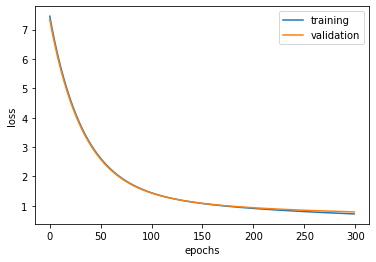

In [737]:
# training-validation loss
plt.plot(history_deep['loss'], label='training')
plt.plot(history_deep['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

The L2 regularization limited the overfitting and the learning curves are stable. However the loss seems to be still quite high. 

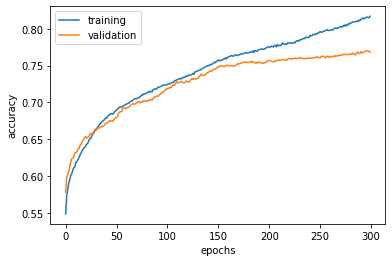

In [738]:
# training-validation accuracy
plt.plot(history_deep['accuracy'], label='training')
plt.plot(history_deep['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [739]:
# internal test 
threshold = 0.50
# convert prediciton to binary 
y_pred = model_deep.predict(X_test_int, verbose=2)
y_pred = y_pred > threshold

print('Accuracy %s' % accuracy_score(y_test_int, y_pred))
print('F1-score %s' % f1_score(y_test_int, y_pred, average=None))
print(classification_report(y_test_int, y_pred))

87/87 - 0s
Accuracy 0.7584330794341676
F1-score [0.70053957 0.79756839]
              precision    recall  f1-score   support

           0       0.71      0.69      0.70      1132
           1       0.79      0.81      0.80      1625

    accuracy                           0.76      2757
   macro avg       0.75      0.75      0.75      2757
weighted avg       0.76      0.76      0.76      2757



## Adam + L2 regularization

In [585]:
def MLP_adam():
    initializer = tf.keras.initializers.GlorotNormal()
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(50, activation='relu', input_dim=input_dim,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.05)))
    model.add(Dense(50, activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l2(0.05)))
    model.add(Dense(50, activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l2(0.05)))
    
    #output layer
    model.add(Dense(1, activation='sigmoid',kernel_initializer=initializer))

    return model

In [586]:
model_adam = MLP_adam()

# define optimizer
adam = Adam(learning_rate=0.001)

model_adam.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
# print model information
model_adam.summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_291 (Dense)            (None, 50)                25950     
_________________________________________________________________
dense_292 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_293 (Dense)            (None, 50)                2550      
_________________________________________________________________
dense_294 (Dense)            (None, 1)                 51        
Total params: 31,101
Trainable params: 31,101
Non-trainable params: 0
_________________________________________________________________


In [814]:
history_adam = model_adam.fit(X_train, y_train, epochs= 200, validation_split=0.3, batch_size=20, shuffle=True).history

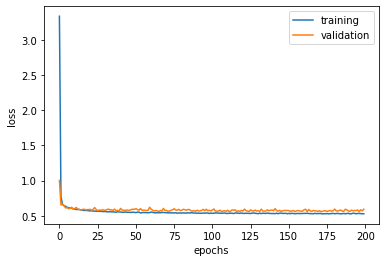

In [588]:
# training-validation loss
plt.plot(history_adam['loss'], label='training')
plt.plot(history_adam['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Using Adam we notice a slight overfitting and learning curve more unstable. 

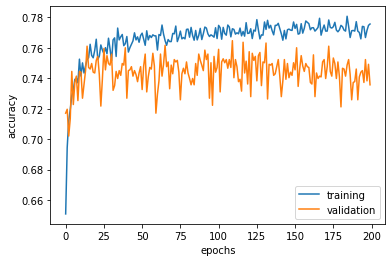

In [589]:
# training-validation accuracy
plt.plot(history_adam['accuracy'], label='training')
plt.plot(history_adam['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [590]:
# internal test 
threshold = 0.50
# convert prediciton to binary 
y_pred = model_adam.predict(X_test_int, verbose=2)
y_pred = y_pred > threshold

print('Accuracy %s' % accuracy_score(y_test_int, y_pred))
print('F1-score %s' % f1_score(y_test_int, y_pred, average=None))
print(classification_report(y_test_int, y_pred))

87/87 - 0s
Accuracy 0.7381211461733769
F1-score [0.63498483 0.79581448]
              precision    recall  f1-score   support

           0       0.74      0.55      0.63      1132
           1       0.74      0.87      0.80      1625

    accuracy                           0.74      2757
   macro avg       0.74      0.71      0.72      2757
weighted avg       0.74      0.74      0.73      2757



On the dataset the performance of SGD seems to be better than Adam. 

## Models : (518, 60, 20, 1)
### SGD + L2 regularization

In [706]:
def MLP_shallow():
    initializer = tf.keras.initializers.GlorotNormal()
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(60, activation='relu', input_dim=input_dim,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.12)))    
    model.add(Dense(20, activation='relu', input_dim=input_dim,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.09)))    

    #output layer
    model.add(Dense(1, activation='sigmoid',kernel_initializer=initializer))

    return model

In [707]:
model_shallow = MLP_shallow()

# define optimizer
sgd = SGD(learning_rate=0.001, momentum=0.7, nesterov=True
)
model_shallow.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
# print model information
model_shallow.summary()

Model: "sequential_120"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_357 (Dense)            (None, 60)                31140     
_________________________________________________________________
dense_358 (Dense)            (None, 20)                1220      
_________________________________________________________________
dense_359 (Dense)            (None, 1)                 21        
Total params: 32,381
Trainable params: 32,381
Non-trainable params: 0
_________________________________________________________________


In [813]:
history_shallow = model_shallow.fit(X_train, y_train, epochs= 700, validation_split=0.3, batch_size=120, shuffle=True).history

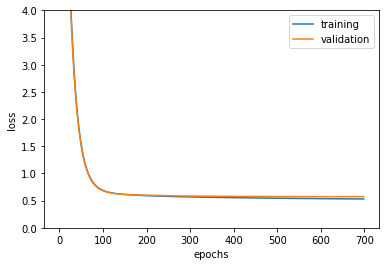

In [709]:
# training-validation loss
plt.plot(history_shallow['loss'], label='training')
plt.plot(history_shallow['val_loss'], label='validation')
plt.ylim(0,4)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

The learning curves are stable and start to converge after 100 epochs. <br> There is a slight overfittin starting from epoch 600. However this seems to be the best model tested so far. 

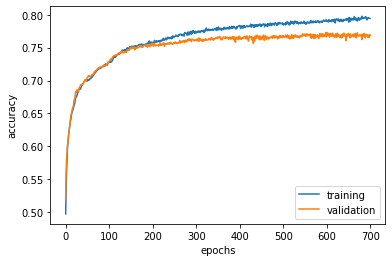

In [710]:
# training-validation accuracy
plt.plot(history_shallow['accuracy'], label='training')
plt.plot(history_shallow['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

After 300 epochs the accuracy on the validaiton set doesn't seem to improve, but it doesn't descrease either.<br>
There are light obscillations but on avereage the accuracy stays stable on 75%.<br> 
The accuracy of the training set instead, continues to increase towards 100%, therefore increasing the number of epochs would cause our model to overfit the data.

In [711]:
# internal test 
threshold = 0.50
# convert prediciton to binary 
y_pred = model_shallow.predict(X_test_int, verbose=2)
y_pred = y_pred > threshold

print('Accuracy %s' % accuracy_score(y_test_int, y_pred))
print('F1-score %s' % f1_score(y_test_int, y_pred, average=None))
print(classification_report(y_test_int, y_pred))

87/87 - 0s
Accuracy 0.7577076532462822
F1-score [0.69188192 0.80035864]
              precision    recall  f1-score   support

           0       0.72      0.66      0.69      1132
           1       0.78      0.82      0.80      1625

    accuracy                           0.76      2757
   macro avg       0.75      0.74      0.75      2757
weighted avg       0.76      0.76      0.76      2757



### SGD - Model less regularized: How does overfitting affects the performance of the model?

In [754]:
def MLP_shallow_ng():
    initializer = tf.keras.initializers.GlorotNormal()
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(60, activation='relu', input_dim=input_dim,kernel_initializer=initializer,kernel_regularizer=regularizers.l2(0.02) ))    
    model.add(Dense(20, activation='relu', input_dim=input_dim,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.02)))    

    #output layer
    model.add(Dense(1, activation='sigmoid',kernel_initializer=initializer))

    return model

In [755]:
model_shallow_ng = MLP_shallow_ng()

# define optimizer
sgd = SGD(learning_rate=0.001, momentum=0.7, nesterov=True
)
model_shallow_ng.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
# print model information
model_shallow_ng.summary()

Model: "sequential_128"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_384 (Dense)            (None, 60)                31140     
_________________________________________________________________
dense_385 (Dense)            (None, 20)                1220      
_________________________________________________________________
dense_386 (Dense)            (None, 1)                 21        
Total params: 32,381
Trainable params: 32,381
Non-trainable params: 0
_________________________________________________________________


In [756]:
history_shallow_ng =model_shallow_ng.fit(X_train, y_train, epochs= 700, validation_split=0.3, batch_size=120, shuffle=True, verbose=False).history

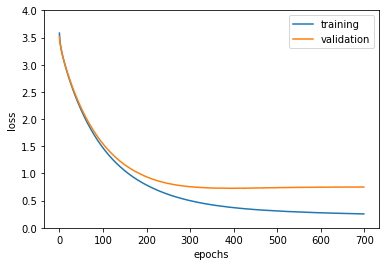

In [757]:
# training-validation loss
plt.plot(history_shallow_ng['loss'], label='training')
plt.plot(history_shallow_ng['val_loss'], label='validation')
plt.ylim(0,4)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

With less regularization we can clearly observe the effects of overfitting. The curves start to diverge significantly after 200 epochs.

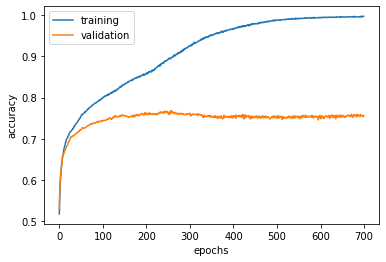

In [758]:
# training-validation accuracy
plt.plot(history_shallow_ng['accuracy'], label='training')
plt.plot(history_shallow_ng['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [761]:
# internal test 
threshold = 0.50
# convert prediciton to binary 
y_pred = model_shallow_ng.predict(X_test_int, verbose=2)
y_pred = y_pred > threshold

print('Accuracy %s' % accuracy_score(y_test_int, y_pred))
print('F1-score %s' % f1_score(y_test_int, y_pred, average=None))
print(classification_report(y_test_int, y_pred))

87/87 - 0s
Accuracy 0.750816104461371
F1-score [0.69206634 0.79074018]
              precision    recall  f1-score   support

           0       0.70      0.68      0.69      1132
           1       0.78      0.80      0.79      1625

    accuracy                           0.75      2757
   macro avg       0.74      0.74      0.74      2757
weighted avg       0.75      0.75      0.75      2757



# Random Search - Hyperparameter tuning

It will be performed first a coarse random search in order to restric the search space. The best model will be then fed to a fine random search which will fine tune the hyperparameters found by the coarse search.

In [101]:
from sklearn.model_selection import RandomizedSearchCV

In [762]:
def ANN(n_layers=2, h_dim=64, activation='relu',learning_rate=0.01,
                momentum=0.0,nesterov=True, optimizer='sgd', lambd=0,  **kwargs):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(60, activation=activation, input_shape=(n_feature,),kernel_regularizer=regularizers.l2(lambd)))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation,kernel_regularizer=regularizers.l2(lambd)))
        
    #linear activation
    model.add(Dense(1, activation='sigmoid'))

    #compile the model
    if optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    else:
        raise ValueError('accepted optimizers are Adam and SGD')
        
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [763]:
# parameters' grid
n_layers = [1, 2]
h_dim = [20, 50]
activation = ['relu']
optimizer = [ 'sgd']
momentum = [random.uniform(0.65,0.8)]
learning_rate=[random.uniform(0.001,0.0017)]
lambd = [random.uniform(0.10, 0.13)]

params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation, momentum=momentum,
             learning_rate=learning_rate, lambd=lambd)

In [766]:
# coarse grid search
model = KerasClassifier(build_fn=ANN)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=10, cv=5)
rnd_result = rnd.fit(X_train, y_train, epochs=700, batch_size=120,shuffle=True, verbose=1)

In [765]:
# results random search - avg 5 fold cv
print("Best: %f using %s" % (rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.752219 using {'optimizer': 'sgd', 'n_layers': 1, 'momentum': 0.7934243001699697, 'learning_rate': 0.0011222982488957825, 'lambd': 0.11744317773833411, 'h_dim': 20, 'activation': 'relu'}
0.752219 (0.013788) with: {'optimizer': 'sgd', 'n_layers': 1, 'momentum': 0.7934243001699697, 'learning_rate': 0.0011222982488957825, 'lambd': 0.11744317773833411, 'h_dim': 20, 'activation': 'relu'}
0.746313 (0.016053) with: {'optimizer': 'sgd', 'n_layers': 2, 'momentum': 0.7934243001699697, 'learning_rate': 0.0011222982488957825, 'lambd': 0.11744317773833411, 'h_dim': 20, 'activation': 'relu'}
0.748801 (0.016338) with: {'optimizer': 'sgd', 'n_layers': 1, 'momentum': 0.7934243001699697, 'learning_rate': 0.0011222982488957825, 'lambd': 0.11744317773833411, 'h_dim': 50, 'activation': 'relu'}
0.747090 (0.014120) with: {'optimizer': 'sgd', 'n_layers': 2, 'momentum': 0.7934243001699697, 'learning_rate': 0.0011222982488957825, 'lambd': 0.11744317773833411, 'h_dim': 50, 'activation': 'relu'}


The best model tested so far has the following architecture: (518, 60, 20).<br>
In the first screening several combination of hyperparameters were tested on the validation set. <br>
The results obtained were satisfactory compared to other architectures, therefore we started a random search starting from that model. The goal was to improve the performance of the model by fine tuning its hyperparameter.

## Check how the best model behaves

In [779]:
def MLP_best():
    initializer = tf.keras.initializers.GlorotNormal()
    input_dim = X_train.shape[1]
    
    model = Sequential()
    model.add(Dense(60, activation='relu', input_dim=input_dim,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.12)))    
    model.add(Dense(20, activation='relu', input_dim=input_dim,kernel_initializer=initializer, kernel_regularizer=regularizers.l2(0.11744317773833411)))    

    #output layer
    model.add(Dense(1, activation='sigmoid',kernel_initializer=initializer))

    return model

In [768]:
model_best = MLP_best()

# define optimizer
sgd = SGD(learning_rate=0.0011222982488957825, momentum=0.7934243001699697, nesterov=True
)
model_best.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
# print model information
model_best.summary()

Model: "sequential_150"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_439 (Dense)            (None, 60)                31140     
_________________________________________________________________
dense_440 (Dense)            (None, 20)                1220      
_________________________________________________________________
dense_441 (Dense)            (None, 1)                 21        
Total params: 32,381
Trainable params: 32,381
Non-trainable params: 0
_________________________________________________________________


In [812]:
history_best =model_best.fit(X_train, y_train, epochs= 700, validation_split=0.3, batch_size=120, shuffle=True, verbose=True).history

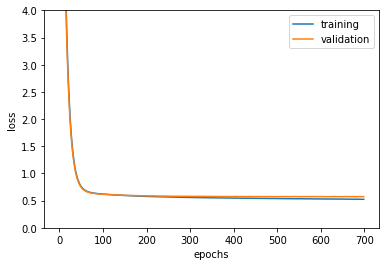

In [770]:
# training-validation loss
plt.plot(history_best['loss'], label='training')
plt.plot(history_best['val_loss'], label='validation')
plt.ylim(0,4)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

The random search improved the learning curves of our Model, even though a very small overfitting occurs after epoch 650.

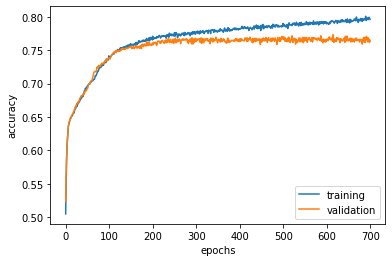

In [771]:
# training-validation accuracy
plt.plot(history_best['accuracy'], label='training')
plt.plot(history_best['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

In [772]:
# internal test 
threshold = 0.50
# convert prediciton to binary 
y_pred = model_best.predict(X_test_int, verbose=2)
y_pred = y_pred > threshold

print('Accuracy %s' % accuracy_score(y_test_int, y_pred))
print('F1-score %s' % f1_score(y_test_int, y_pred, average=None))
print(classification_report(y_test_int, y_pred))

87/87 - 0s
Accuracy 0.7598839318099383
F1-score [0.69549218 0.80179641]
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      1132
           1       0.78      0.82      0.80      1625

    accuracy                           0.76      2757
   macro avg       0.75      0.75      0.75      2757
weighted avg       0.76      0.76      0.76      2757



## If we use Adam instead of SGD will the performance improve?

In [773]:
model_best_adam = MLP_best()

# define optimizer
adam = Adam(learning_rate=0.0011222982488957825)
model_best_adam.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
# print model information
model_best_adam.summary()

Model: "sequential_151"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_442 (Dense)            (None, 60)                31140     
_________________________________________________________________
dense_443 (Dense)            (None, 20)                1220      
_________________________________________________________________
dense_444 (Dense)            (None, 1)                 21        
Total params: 32,381
Trainable params: 32,381
Non-trainable params: 0
_________________________________________________________________


In [811]:
history_best_adam =model_best_adam.fit(X_train, y_train, epochs= 700, validation_split=0.3, batch_size=120, shuffle=True, verbose=True).history

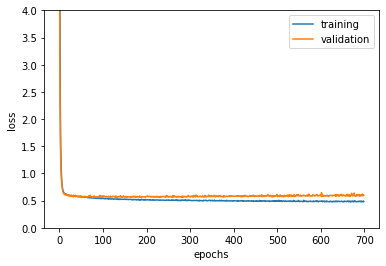

In [775]:
# training-validation loss
plt.plot(history_best_adam['loss'], label='training')
plt.plot(history_best_adam['val_loss'], label='validation')
plt.ylim(0,4)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

Maintaining the same configuration and changing the optimizer, we notice that with Adam optimizer the overfitting increases.

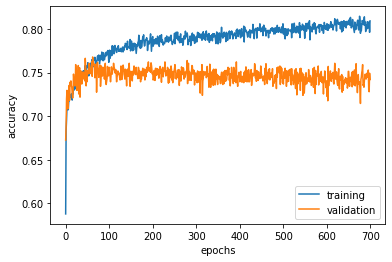

In [776]:
# training-validation accuracy
plt.plot(history_best_adam['accuracy'], label='training')
plt.plot(history_best_adam['val_accuracy'], label='validation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

## Let's do another Random Search testing other architectures

In [103]:
def build_model(n_layers=2, h_dim=64, activation='relu',learning_rate=0.01,
                momentum=0.0,nesterov=True, optimizer='adam', lambd=0, dropout_rate=0, **kwargs):
    # define the model
    model = Sequential()

    n_feature = X_train.shape[1]
    
    model.add(Dense(h_dim, activation=activation, input_shape=(n_feature,),kernel_regularizer=regularizers.l2(lambd)))
    model.add(Dropout(dropout_rate))
    for i in range(n_layers-1):
        model.add(Dense(h_dim, activation=activation,kernel_regularizer=regularizers.l2(lambd)))
        model.add(Dropout(dropout_rate))

    #linear activation
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(lambd)))

    #compile the model
    if optimizer == 'adam':
        optimizer = Adam(lr=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=nesterov)
    else:
        raise ValueError('accepted optimizers are Adam and SGD')
        
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

#### Coarse Random-Search 

In [1135]:
# parameters' grid
n_layers = [1, 2, 3]
h_dim = [30, 50, 128]
activation = ['relu']
optimizer = ['adam', 'sgd']
momentum = [0.5, 0.8]
learning_rate=[0.1, 0.01, 0.001, 0.0001]
lambd = [0, 1e-1, 1e-2, 1e-3]

params = dict(optimizer=optimizer, n_layers=n_layers, h_dim=h_dim, activation=activation, momentum=momentum,
             learning_rate=learning_rate, lambd=lambd)

In [810]:
# coarse grid search
model = KerasClassifier(build_fn=build_model)

rnd = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=100, cv=5)
rnd_result = rnd.fit(X_train, y_train, epochs=500, batch_size=20,shuffle=True, verbose=1)

In [1137]:
# results random search - avg 5 fold cv
print("Best: %f using %s" % (rnd_result.best_score_, rnd_result.best_params_))
means = rnd_result.cv_results_['mean_test_score']
stds = rnd_result.cv_results_['std_test_score']
params = rnd_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.753306 using {'optimizer': 'adam', 'n_layers': 1, 'momentum': 0.5, 'learning_rate': 0.0001, 'lambd': 0.01, 'h_dim': 128, 'activation': 'relu'}
0.739161 (0.011426) with: {'optimizer': 'adam', 'n_layers': 2, 'momentum': 0.5, 'learning_rate': 0.0001, 'lambd': 0.01, 'h_dim': 30, 'activation': 'relu'}
0.732633 (0.013616) with: {'optimizer': 'adam', 'n_layers': 1, 'momentum': 0.8, 'learning_rate': 0.001, 'lambd': 0.001, 'h_dim': 128, 'activation': 'relu'}
0.740250 (0.014995) with: {'optimizer': 'sgd', 'n_layers': 2, 'momentum': 0.8, 'learning_rate': 0.01, 'lambd': 0.01, 'h_dim': 50, 'activation': 'relu'}
0.743978 (0.009656) with: {'optimizer': 'adam', 'n_layers': 3, 'momentum': 0.8, 'learning_rate': 0.0001, 'lambd': 0, 'h_dim': 128, 'activation': 'relu'}
0.723150 (0.012094) with: {'optimizer': 'adam', 'n_layers': 2, 'momentum': 0.8, 'learning_rate': 0.01, 'lambd': 0, 'h_dim': 50, 'activation': 'relu'}
0.729988 (0.007538) with: {'optimizer': 'adam', 'n_layers': 1, 'momentum': 0.8, 'le

###### Result Coarse Random-Search:
Best Model:
- 0.753306 mean validation accuracy 
- using {'optimizer': 'adam', 'n_layers': 1, 'momentum': 0.5, 'learning_rate': 0.0001, 'lambd': 0.01, 'h_dim': 128, 'activation': 'relu'}

After searching for other Model topology and parameters, we chose a model with 2 hidden layers. 

# Retrain on Development Set and Test it

**Best Model Architecture:**<br>

- Layers: (518, 60, 20, 1)<br>
- Activation functions: (ReLU, Sigmoid)<br>
- Weight Initialization: GlorotNormal<br>
- Optimizer: SGD with Nesterov momentum<br>
- Loss: Binary cross entropy <br>
- Learning rate: 0.001122<br>
- Momentum: 0.79342<br>
- L2 Regularization: 0.11744 <br>

The model is retrained on the full Development set (Training set + Internal Test set) and then tested on the Test set which was never used in the Model selection phase.

In [793]:
model_final = MLP_best()

# define optimizer
sgd = SGD(learning_rate=0.0011222982488957825, momentum=0.7934243001699697, nesterov=True
)
model_final.compile(optimizer=sgd, loss='binary_crossentropy', metrics=['accuracy'])
# print model information
model_final.summary()

Model: "sequential_154"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_451 (Dense)            (None, 60)                31140     
_________________________________________________________________
dense_452 (Dense)            (None, 20)                1220      
_________________________________________________________________
dense_453 (Dense)            (None, 1)                 21        
Total params: 32,381
Trainable params: 32,381
Non-trainable params: 0
_________________________________________________________________


In [809]:
history_final= model_final.fit(X_dev, y_dev, epochs= 700, batch_size=120, shuffle=True).history

The **expected loss on the test set is 0.5208** with an accuracy of **78.61%**

## Test the model on the test set

In [795]:
# evaluate on Test set
model_best.evaluate(X_test,y_test)

124/124 [==============================] - 0s 2ms/step - loss: 0.5850 - accuracy: 0.7550


[0.5850498676300049, 0.7550139427185059]

The **actual loss on the test set is 0.5850** which is almost in line to the prediction made before. The **accuracy instead is 75.50%**. The accuracy was off by a factor of almost 2% points.

In [799]:
# test set results
threshold = 0.51
# convert prediciton to binary 
y_pred = model_final.predict(X_test, verbose=2)
y_pred = y_pred > threshold

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

124/124 - 0s
Accuracy 0.7605991368367606
F1-score [0.71117917 0.79557772]
              precision    recall  f1-score   support

           0       0.71      0.72      0.71      1622
           1       0.80      0.79      0.80      2317

    accuracy                           0.76      3939
   macro avg       0.75      0.75      0.75      3939
weighted avg       0.76      0.76      0.76      3939



In [804]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

In [805]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cf_matrix)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [806]:
def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

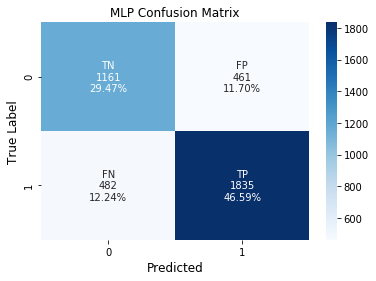

In [807]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix,'MLP Confusion Matrix')

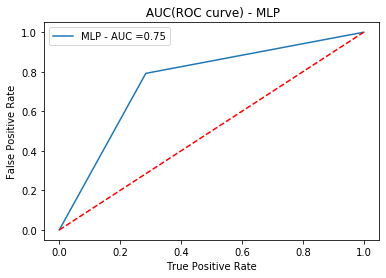

In [808]:
plot_roc_curve(y_test, y_pred, 'MLP')